In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tldextract
import seaborn as sns
import os
print("Library imported!")

Library imported!


In [2]:
data=pd.read_csv('cn_website_activity_csv/173.csv')

## 1. Data preparation

#### 1.1. Add one column 'ScrollDepth_count' (0/1). 0 if there is NaN for ScrollDepth, and 1 if there is any number for ScrollDepth.

In [3]:
data.isnull().sum()

infinity_id           0
InfinityID            0
UUID                240
Brand                 0
Channel          124354
PageURL           12422
Author          1273826
Category              0
ArticleTitle     252910
Location         151583
Country            4454
HalTopics       3075031
HalKeyword       691468
RefererURL        34594
ScrollDepth     1962702
Browser               4
SessionID        562218
dtype: int64

In [4]:
data['ScrollDepth_count'] = 0
data.loc[data.ScrollDepth>0, 'ScrollDepth_count']=1

In [5]:
#result
data['ScrollDepth_count'].value_counts()

0    1962977
1    1112054
Name: ScrollDepth_count, dtype: int64

#### 1.2. Add a new column called 'Referer', keeping only the company/brand information of  RefererURL. 
For example, if the RefererURL is https://www.google.com/, we only keep google in the Refer column.

In [6]:
#replace NaN with blank
data["RefererURL"] = data.RefererURL.fillna('')

In [7]:
#convert to string type
data['RefererURL'] = data['RefererURL'].astype(str)

In [8]:
#replace // to blank 
data['RefererURL']= data["RefererURL"].apply(lambda x: "" if x=="//" else x)

In [9]:
#deal with abnormal format 'adroid_app...'
data['RefererURL'] = data['RefererURL'].apply(lambda x: 'android_app' if 'android-app'in x else x)

In [10]:
#extract domain using tldextract package
data['Referer'] = data['RefererURL'].apply(lambda x: tldextract.extract(x).domain if 'http' in x else x)

#### 1.3. Transform Channel to lower case

In [11]:
data.Channel = data.Channel.fillna('')

In [12]:
data['Channel'] = data['Channel'].apply(lambda x: x.lower())

#### 1.4. Fill in na

In [13]:
data['Country'] = data['Country'].fillna('United States')
data['Location'] = data['Location'].fillna('Unknown')

#### 1.5. Add new column "first author"

In [14]:
data['Author'] = data['Author'].fillna('[]')
data.Author = data.Author.apply(lambda x:x.lower())

In [15]:
data['Author'] = data['Author'].map(lambda x: x.lstrip('[').rstrip(']'))
newDF = data['Author'].str.split(',',3,True)
newDF.columns = ['Author1', 'Author2','Author3','Author4']

In [16]:
data_new = pd.concat([data,newDF],axis=1,ignore_index=False)

In [17]:
data_new.drop(['Author2','Author3','Author4'],axis = 1,inplace = True)

In [18]:
data_new.shape

(3075031, 20)

#### 1.6. sample balanced data

In [19]:
data_1 = data_new.loc[data_new.ScrollDepth_count == 1,:].sample(n=10000,random_state = 123)

In [20]:
data_0 = data_new.loc[data_new.ScrollDepth_count == 0,:].sample(n=10000,random_state = 123)

In [21]:
data_sample = result = pd.concat([data_1,data_0])

In [22]:
data_sample.ScrollDepth_count.value_counts()

1    10000
0    10000
Name: ScrollDepth_count, dtype: int64

In [23]:
data_sample.shape

(20000, 20)

In [24]:
data_sample.isnull().sum()

infinity_id              0
InfinityID               0
UUID                     1
Brand                    0
Channel                  0
PageURL                 70
Author                   0
Category                 0
ArticleTitle          1521
Location                 0
Country                  0
HalTopics            20000
HalKeyword            3629
RefererURL               0
ScrollDepth           9998
Browser                  0
SessionID             2863
ScrollDepth_count        0
Referer                  0
Author1                  0
dtype: int64

# 2. Linear Model
Using feature 'Brand','Browser','Category','Country','Author1'

In [44]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

In [27]:
independent_all = data_sample.loc[:,['Brand','Browser','Category','Country','Author1']]
independent_all_dummy = pd.get_dummies(independent_all)
dependent = data_sample.loc[:,'ScrollDepth_count']
independent_all_dummy.shape

(20000, 2019)

In [28]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_all_dummy, dependent, test_size=0.2, random_state=123)
ols = OLS(endog=y_trainset, exog=X_trainset).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      ScrollDepth_count   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     6.084
Date:                Fri, 13 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:42:35   Log-Likelihood:                -7036.9
No. Observations:               16000   AIC:                         1.768e+04
Df Residuals:                   14198   BIC:                         3.152e+04
Df Model:                        1801                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================================
                                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Brand_allure                                                                                                       0.0047      0.021      0.229      0.819      -0.036       0.045
Brand_architectural-digest                                                                                         0.1373      0.030      4.652      0.000       0.079       0.195
Brand_ars-technica                                                                                                -0.0551      0.020     -2.746      0.006      -0.094      -0.016
Brand_bon-appetit                                                                                                  0.0029      0.024      0.117      0.907      -0.045       0.051
Brand_brides                                                                                                      -0.0157      0.035     -0.443      0.658      -0.085       0.054
Brand_conde-nast-traveler                                                                                         -0.0012      0.035     -0.035      0.972      -0.070       0.068
Brand_epicurious                                                                                                   0.0333      0.019      1.739      0.082      -0.004       0.071
Brand_glamour                                                                                                     -0.0039      0.023     -0.168      0.866      -0.050       0.042
Brand_golf-digest                                                                                                  0.1821      0.024      7.542      0.000       0.135       0.229
Brand_gq                                                                                                           0.0440      0.022      2.045      0.041       0.002       0.086
Brand_pitchfork                                                                                                   -0.0570      0.029     -1.997      0.046      -0.113      -0.001
Brand_self                                                                                                         0.0205      0.025      0.813      0.416      -0.029       0.070
Brand_teen-vogue                                                                                                  -0.0141      0.039     -0.364      0.716      -0.090       0.062
Brand_the-new-yorker                                                                                               0.0818      0.022      3.792      0.000       0.040       0.124
Brand_vanity-fair                       

In [29]:
y_pre_train = ols.predict(X_trainset)
y_pre_test = ols.predict(X_testset)
y_pre_train_0_1 = y_pre_train >.5
y_pre_test_0_1 = y_pre_test >.5

print("Training Set Accuracy for Linear Regression: ", accuracy_score(y_trainset, y_pre_train_0_1))
print("Test Set Accuracy for Linear Regression: ", accuracy_score(y_testset, y_pre_test_0_1))

Training Set Accuracy for Linear Regression:  0.7898125
Test Set Accuracy for Linear Regression:  0.73925


In [30]:
# check the confusion matrix
pd.crosstab(y_testset,y_pre_test_0_1,margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True,All
Actual,,,
0,1485,530,2015
1,513,1472,1985
All,1998,2002,4000


In [31]:
roc_auc_score(y_testset, y_pre_test)

0.814328555981274

Accuracy is 0.74, auc is 0.81.

In [32]:
# Search for significant features
ols.pvalues[ols.pvalues < 0.05].index

Index(['Brand_architectural-digest', 'Brand_ars-technica', 'Brand_golf-digest',
       'Brand_gq', 'Brand_pitchfork', 'Brand_the-new-yorker', 'Brand_vogue',
       'Browser_Apple Mail', 'Browser_BingPreview', 'Browser_Chrome',
       ...
       'Author1_'tom philip'', 'Author1_'tommy werner'',
       'Author1_'troy patterson'', 'Author1_'tynan sinks'',
       'Author1_'vanity fair magazine'', 'Author1_'wendy sy '',
       'Author1_'william waldron'', 'Author1_'yang-yi goh'',
       'Author1_'yolanda crous'', 'Author1_'zach helfand''],
      dtype='object', length=320)

In [33]:
sig_fea = ols.pvalues[ols.pvalues < 0.05].index.tolist()
len(sig_fea)

320

In [34]:
independent_all_dummy_2 = independent_all_dummy.loc[:,sig_fea]

In [35]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_all_dummy_2, dependent, test_size=0.2, random_state=123)
ols = OLS(endog=y_trainset, exog=X_trainset).fit()
ols.summary()

E:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
E:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
E:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
E:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      ScrollDepth_count   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     108.2
Date:                Fri, 13 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:43:53   Log-Likelihood:                -8152.4
No. Observations:               16000   AIC:                         1.691e+04
Df Residuals:                   15697   BIC:                         1.924e+04
Df Model:                         303                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Brand_architectural-digest                         0.1220      0.020      6.165      0.000       0.083       0.161
Brand_ars-technica                                -0.0640      0.018     -3.461      0.001      -0.100      -0.028
Brand_golf-digest                                  0.1505      0.023      6.679      0.000       0.106       0.195
Brand_gq                                          -0.0094      0.016     -0.597      0.550      -0.040       0.021
Brand_pitchfork                                   -0.1273      0.022     -5.908      0.000      -0.170      -0.085
Brand_the-new-yorker                               0.1147      0.013      8.698      0.000       0.089       0.141
Brand_vogue                                        0.2888      0.012     24.405      0.000       0.266       0.312
Browser_Apple Mail                                -0.3671      0.130     -2.816      0.005      -0.623      -0.112
Browser_BingPreview                               -0.3683      0.037    -10.045      0.000      -0.440      -0.296
Browser_Chrome                                     0.0577      0.010      6.069      0.000       0.039       0.076
Browser_Chrome Mobile                              0.1066      0.012      9.000      0.000       0.083       0.130
Browser_Chromium                                  -0.2921      0.074     -3.956      0.000      -0.437      -0.147
Browser_Edge                                       0.0703      0.024      2.870      0.004       0.022       0.118
Browser_Facebook                                   0.0677      0.015      4.615      0.000       0.039       0.096
Browser_Flipboard                                  0.0633      0.030      2.134      0.033       0.005       0.121
Browser_HeadlessChrome                            -0.3014      0.129     -2.338      0.019      -0.554      -0.049
Browser_Instagram                                  0.0607      0.026      2.368      0.018       0.010       0.111
Browser_Mobile Safari                              0.1013      0.009     11.654      0.000       0.084       0.118
Browser_Pinterest                                  0.1193      0.035      3.385      0.001       0.050       0.188
Browser_Samsung Internet                           0.1593      0.029      5.451      0.000       0.102       0.217
Category_cmSubscribe                               0.1683      0.052      3.266      0.001       0.067       0.269
Category_general                                   0.4384      0.008     55.885      0.000       0.423       0.454
Country_Bangladesh                                -0.8058      0.422     -1.909      0.056      -1.633       0.022
Country_Canada                                    -0.1652      0.053     -3.111      0.002   

In [36]:
y_pre_train = ols.predict(X_trainset)
y_pre_test = ols.predict(X_testset)
y_pre_train_0_1 = y_pre_train >.5
y_pre_test_0_1 = y_pre_test >.5

print("Training Set Accuracy for Linear Regression: ", accuracy_score(y_trainset, y_pre_train_0_1))
print("Test Set Accuracy for Linear Regression: ", accuracy_score(y_testset, y_pre_test_0_1))

Training Set Accuracy for Linear Regression:  0.7483125
Test Set Accuracy for Linear Regression:  0.72425


In [37]:
# check the confusion matrix
pd.crosstab(y_testset,y_pre_test_0_1,margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True,All
Actual,,,
0,1430,585,2015
1,518,1467,1985
All,1948,2052,4000


In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_testset, y_pre_test)

0.810820608659237

Accuracy is 0.72, AUC is 0.81.

# 3. Logistic Model 
Using feature 'Brand','Browser','Category','Country','Author1'

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc
from sklearn import metrics

In [40]:
independent_all = data_sample.loc[:,['Brand','Browser','Category','Country','Author1']]
independent_all_dummy = pd.get_dummies(independent_all)
independent_all_dummy.shape

(20000, 2019)

Training Accuracy for Logistic Regression:  0.7910625
Test Accuracy for Logistic Regression:  0.7435
AUC score is:  0.8158063891093874
      0     1
0  1459   556
1   470  1515
             precision    recall  f1-score   support

          0       0.76      0.72      0.74      2015
          1       0.73      0.76      0.75      1985

avg / total       0.74      0.74      0.74      4000



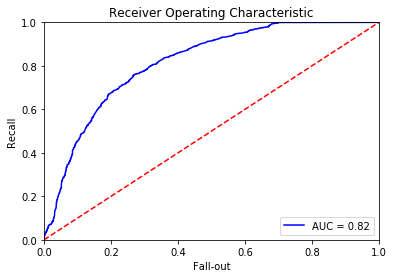

In [47]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_all_dummy, dependent, test_size=0.2, random_state=123)
logistic_mod = LogisticRegression(C=1000000, fit_intercept=True) #The C value here is a way to prevent regularization
logistic_mod.fit(X_trainset, y_trainset)

y_pred_train_logistic_mod = logistic_mod.predict_proba(X_trainset)[:,1]
y_pred_test_logistic_mod = logistic_mod.predict_proba(X_testset)[:,1]

y_pred_train_logistic_mod_0_1 = y_pred_train_logistic_mod > 0.5
y_pred_test_logistic_mod_0_1 = y_pred_test_logistic_mod > 0.5

print("Training Accuracy for Logistic Regression: ", accuracy_score(y_trainset, y_pred_train_logistic_mod_0_1))
print("Test Accuracy for Logistic Regression: ", accuracy_score(y_testset, y_pred_test_logistic_mod_0_1))
print('AUC score is: ', roc_auc_score(y_testset, y_pred_test_logistic_mod))
print(pd.DataFrame(metrics.confusion_matrix(y_testset, y_pred_test_logistic_mod_0_1)))
print(metrics.classification_report(y_testset, y_pred_test_logistic_mod_0_1))

false_positive_rate, recall, thresholds = roc_curve(y_testset, y_pred_test_logistic_mod)
roc_auc=auc(false_positive_rate,recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

Training Accuracy for Logistic Regression:  0.7481875
Test Accuracy for Logistic Regression:  0.723
AUC score is:  0.8128787244282492
      0     1
0  1453   562
1   546  1439
             precision    recall  f1-score   support

          0       0.73      0.72      0.72      2015
          1       0.72      0.72      0.72      1985

avg / total       0.72      0.72      0.72      4000



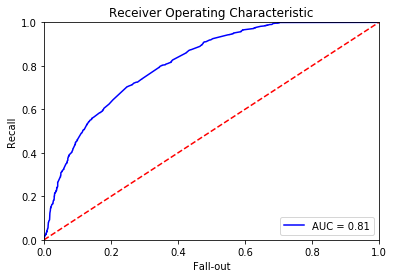

In [48]:
independent_all_dummy_2 = independent_all_dummy.loc[:,sig_fea]
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_all_dummy_2, dependent, test_size=0.2, random_state=123)
logistic_mod = LogisticRegression(C=1000000, fit_intercept=True) #The C value here is a way to prevent regularization
logistic_mod.fit(X_trainset, y_trainset)

y_pred_train_logistic_mod = logistic_mod.predict_proba(X_trainset)[:,1]
y_pred_test_logistic_mod = logistic_mod.predict_proba(X_testset)[:,1]

y_pred_train_logistic_mod_0_1 = y_pred_train_logistic_mod > 0.5
y_pred_test_logistic_mod_0_1 = y_pred_test_logistic_mod > 0.5

print("Training Accuracy for Logistic Regression: ", accuracy_score(y_trainset, y_pred_train_logistic_mod_0_1))
print("Test Accuracy for Logistic Regression: ", accuracy_score(y_testset, y_pred_test_logistic_mod_0_1))
print('AUC score is: ', roc_auc_score(y_testset, y_pred_test_logistic_mod))
print(pd.DataFrame(metrics.confusion_matrix(y_testset, y_pred_test_logistic_mod_0_1)))
print(metrics.classification_report(y_testset, y_pred_test_logistic_mod_0_1))

false_positive_rate, recall, thresholds = roc_curve(y_testset, y_pred_test_logistic_mod)
roc_auc=auc(false_positive_rate,recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

# 4. Random Forest Tree Model 
using feature 'Brand','Browser','Category','Country','Author1'

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import datasets, linear_model

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [50]:
independent_all = data_sample.loc[:,['Brand','Browser','Category','Country','Author1']]
dependent = data_sample.loc[:,'ScrollDepth_count']
independent_all_dummy = pd.get_dummies(independent_all)
independent_all_dummy.shape

(20000, 2019)

In [51]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_all_dummy, dependent, test_size=0.2, random_state=123)

In [52]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 123) 
rf.fit(X_trainset, y_trainset)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

Training Accuracy for Logistic Regression:  0.837125
Test Accuracy for Logistic Regression:  0.73475
AUC score is:  0.8043041171065871
      0     1
0  1449   566
1   495  1490
             precision    recall  f1-score   support

          0       0.75      0.72      0.73      2015
          1       0.72      0.75      0.74      1985

avg / total       0.74      0.73      0.73      4000



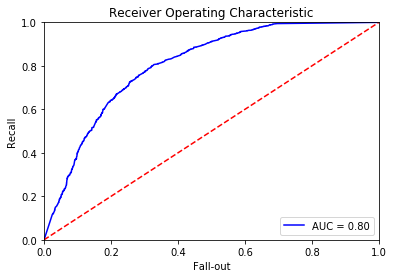

In [53]:
y_pred_train_rf = rf.predict(X_trainset)
y_pred_test_rf = rf.predict(X_testset)

y_pred_train_rf_0_1 = y_pred_train_rf > 0.5
y_pred_test_rf_0_1 = y_pred_test_rf > 0.5

print("Training Accuracy for Logistic Regression: ", accuracy_score(y_trainset, y_pred_train_rf_0_1))
print("Test Accuracy for Logistic Regression: ", accuracy_score(y_testset, y_pred_test_rf_0_1))
print('AUC score is: ', roc_auc_score(y_testset, y_pred_test_rf))
print(pd.DataFrame(metrics.confusion_matrix(y_testset, y_pred_test_rf_0_1)))
print(metrics.classification_report(y_testset, y_pred_test_rf_0_1))

false_positive_rate, recall, thresholds = roc_curve(y_testset, y_pred_test_rf)
roc_auc=auc(false_positive_rate,recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

In [54]:
var_imp = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_),independent_all_dummy.columns), reverse=True)

In [55]:
var_imp_df = pd.DataFrame(var_imp)
var_imp_df.head()

,0,1
0,0.2527,Category_general
1,0.0535,Author1_
2,0.0386,Brand_vogue
3,0.0268,Brand_conde-nast-traveler
4,0.0240,Browser_Chrome


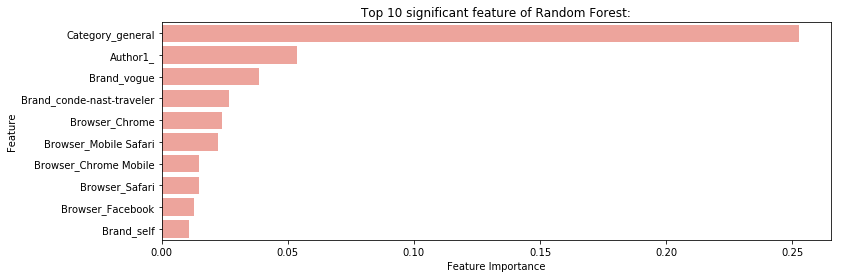

In [56]:
# Top 10 significant feature
n_features=10 
plt.figure(figsize=(12,4))
sns.barplot(y=var_imp_df.iloc[:10,1],x=var_imp_df.iloc[:10,0], alpha=0.8,orient = 'h',color = 'salmon')
plt.yticks(np.arange(n_features),var_imp_df.iloc[:10,1]) 
plt.title("Top 10 significant feature of Random Forest:") 
plt.xlabel('Feature Importance') 
plt.ylabel('Feature') 
plt.show()

In [57]:
independent_all_dummy_2 = independent_all_dummy.loc[:,sig_fea]
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_all_dummy_2, dependent, test_size=0.2, random_state=123)

In [58]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 123) 
rf.fit(X_trainset, y_trainset)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

Training Accuracy for Logistic Regression:  0.758125
Test Accuracy for Logistic Regression:  0.72325
AUC score is:  0.8094821583714085
      0     1
0  1430   585
1   522  1463
             precision    recall  f1-score   support

          0       0.73      0.71      0.72      2015
          1       0.71      0.74      0.73      1985

avg / total       0.72      0.72      0.72      4000



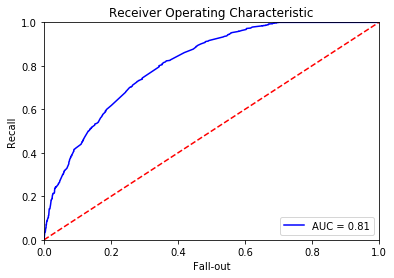

In [59]:
y_pred_train_rf = rf.predict(X_trainset)
y_pred_test_rf = rf.predict(X_testset)

y_pred_train_rf_0_1 = y_pred_train_rf > 0.5
y_pred_test_rf_0_1 = y_pred_test_rf > 0.5

print("Training Accuracy for Logistic Regression: ", accuracy_score(y_trainset, y_pred_train_rf_0_1))
print("Test Accuracy for Logistic Regression: ", accuracy_score(y_testset, y_pred_test_rf_0_1))
print('AUC score is: ', roc_auc_score(y_testset, y_pred_test_rf))
print(pd.DataFrame(metrics.confusion_matrix(y_testset, y_pred_test_rf_0_1)))
print(metrics.classification_report(y_testset, y_pred_test_rf_0_1))

false_positive_rate, recall, thresholds = roc_curve(y_testset, y_pred_test_rf)
roc_auc=auc(false_positive_rate,recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

# 5. Neural Network
using feature 'Brand','Browser','Category','Country','Author1'

In [61]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dnn_app_utils_v3 import *
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)

E:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [62]:
independent = data_sample.loc[:,['Brand','Author1','Browser','Category','Country']]
dependent = data_sample.loc[:,'ScrollDepth_count']
independent_dummy = pd.get_dummies(independent)
independent_dummy.shape

(20000, 2019)

In [63]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_dummy, dependent, test_size=0.2, random_state=123)

In [64]:
# Explore dataset 
m_train = X_trainset.shape[0]
m_test = X_testset.shape[0]
X_trainset = X_trainset.T
y_trainset = y_trainset.reshape((1, y_trainset.shape[0]))
X_testset = X_testset.T
y_testset = y_testset.reshape((1, y_testset.shape[0]))

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("X_trainset shape: " + str(X_trainset.shape))
print ("y_trainset shape: " + str(y_trainset.shape))
print ("X_testset shape: " + str(X_testset.shape))
print ("y_testset shape: " + str(y_testset.shape))

Number of training examples: 16000
Number of testing examples: 4000
X_trainset shape: (2019, 16000)
y_trainset shape: (1, 16000)
X_testset shape: (2019, 4000)
y_testset shape: (1, 4000)


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


## 2-layer neural network

In [65]:
### CONSTANTS DEFINING THE MODEL ####
n_x = X_trainset.shape[0]     
n_h = 20
n_y = 1
layers_dims = (n_x, n_h, n_y)
layers_dims

(2019, 20, 1)

In [66]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6931212310228996
Cost after iteration 100: 0.6926541749192009
Cost after iteration 200: 0.6900012351209168
Cost after iteration 300: 0.676092583968564
Cost after iteration 400: 0.6300325560980052
Cost after iteration 500: 0.5799113731488553
Cost after iteration 600: 0.5585772468112506
Cost after iteration 700: 0.547768142626895
Cost after iteration 800: 0.5404410458841171
Cost after iteration 900: 0.5350339189880028
Cost after iteration 1000: 0.5308099666382048
Cost after iteration 1100: 0.5273416362359871
Cost after iteration 1200: 0.5243738527920252
Cost after iteration 1300: 0.5217535011694951
Cost after iteration 1400: 0.519387409094847
Cost after iteration 1500: 0.5172106331101627
Cost after iteration 1600: 0.5151829788223808
Cost after iteration 1700: 0.5132793218433025
Cost after iteration 1800: 0.5114772825799865
Cost after iteration 1900: 0.509767272793037
Cost after iteration 2000: 0.5081325175229133
Cost after iteration 2100: 0.5065698287114379
Cost

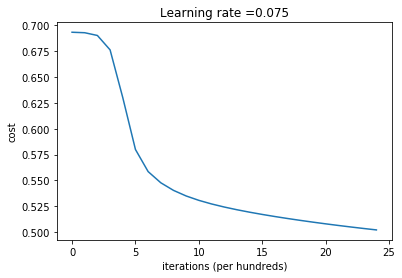

In [67]:
parameters = two_layer_model(X_trainset, y_trainset, layers_dims = (n_x, n_h, n_y), learning_rate = 0.075,num_iterations = 2500, print_cost=True)

In [68]:
predictions_train = predict(X_trainset, y_trainset, parameters)

Accuracy: 0.7356250000000002
AUC: 0.8219854679176607


In [69]:
predictions_test = predict(X_testset, y_testset, parameters)

Accuracy: 0.7310000000000002
AUC: 0.81249895306611


In [85]:
# Using significant features
independent_all_dummy_2 = independent_all_dummy.loc[:,sig_fea]
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_all_dummy_2, dependent, test_size=0.2, random_state=123)

In [86]:
# Explore dataset 
m_train = X_trainset.shape[0]
m_test = X_testset.shape[0]
X_trainset = X_trainset.T
y_trainset = y_trainset.reshape((1, y_trainset.shape[0]))
X_testset = X_testset.T
y_testset = y_testset.reshape((1, y_testset.shape[0]))

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("X_trainset shape: " + str(X_trainset.shape))
print ("y_trainset shape: " + str(y_trainset.shape))
print ("X_testset shape: " + str(X_testset.shape))
print ("y_testset shape: " + str(y_testset.shape))

Number of training examples: 16000
Number of testing examples: 4000
X_trainset shape: (320, 16000)
y_trainset shape: (1, 16000)
X_testset shape: (320, 4000)
y_testset shape: (1, 4000)


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


In [ ]:
### CONSTANTS DEFINING THE MODEL ####
n_x = X_trainset.shape[0]     
n_h = 20
n_y = 1
layers_dims = (n_x, n_h, n_y)
layers_dims

Cost after iteration 0: 0.6930741415845301
Cost after iteration 100: 0.692682675779668
Cost after iteration 200: 0.6909709991534246
Cost after iteration 300: 0.6837926295277956
Cost after iteration 400: 0.6598930593478746
Cost after iteration 500: 0.6184404560235773
Cost after iteration 600: 0.5914406616363278
Cost after iteration 700: 0.579795938984246
Cost after iteration 800: 0.5723368580677525
Cost after iteration 900: 0.5663646354928836
Cost after iteration 1000: 0.5613574002645849
Cost after iteration 1100: 0.5569785210858583
Cost after iteration 1200: 0.5530625092096438
Cost after iteration 1300: 0.5495083196641445
Cost after iteration 1400: 0.5462379153074771
Cost after iteration 1500: 0.543199954400545
Cost after iteration 1600: 0.5403556284231049
Cost after iteration 1700: 0.5376782467518432
Cost after iteration 1800: 0.5351486655760203
Cost after iteration 1900: 0.5327545846619559
Cost after iteration 2000: 0.5304895654321491
Cost after iteration 2100: 0.5283426412481733
Cos

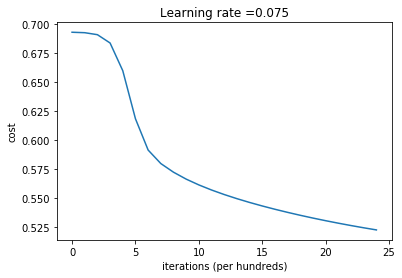

In [87]:
parameters = two_layer_model(X_trainset, y_trainset, layers_dims = (n_x, n_h, n_y), learning_rate = 0.075,num_iterations = 2500, print_cost=True)

In [88]:
predictions_train = predict(X_trainset, y_trainset, parameters)
predictions_test = predict(X_testset, y_testset, parameters)

Accuracy: 0.7171875000000003
AUC: 0.8056010665662497
Accuracy: 0.7120000000000002
AUC: 0.7969608290466339


## L-layer deep neural network

In [89]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [90]:
independent = data_sample.loc[:,['Brand','Author1','Browser','Category','Country']]
dependent = data_sample.loc[:,'ScrollDepth_count']
independent_dummy = pd.get_dummies(independent)
independent_dummy.shape

(20000, 2019)

In [91]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_all_dummy, dependent, test_size=0.2, random_state=123)

In [92]:
# Explore dataset 
m_train = X_trainset.shape[0]
m_test = X_testset.shape[0]
X_trainset = X_trainset.T
y_trainset = y_trainset.reshape((1, y_trainset.shape[0]))
X_testset = X_testset.T
y_testset = y_testset.reshape((1, y_testset.shape[0]))

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("X_trainset shape: " + str(X_trainset.shape))
print ("y_trainset shape: " + str(y_trainset.shape))
print ("X_testset shape: " + str(X_testset.shape))
print ("y_testset shape: " + str(y_testset.shape))

Number of training examples: 16000
Number of testing examples: 4000
X_trainset shape: (2019, 16000)
y_trainset shape: (1, 16000)
X_testset shape: (2019, 4000)
y_testset shape: (1, 4000)


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


In [93]:
### CONSTANTS ###
layers_dims = [X_trainset.shape[0], 100, 50, 10, 1] #  4-layer model
layers_dims

[2019, 100, 50, 10, 1]

Cost after iteration 0: 0.693500
Cost after iteration 100: 0.686051
Cost after iteration 200: 0.675221
Cost after iteration 300: 0.658120
Cost after iteration 400: 0.632233
Cost after iteration 500: 0.600326
Cost after iteration 600: 0.572900
Cost after iteration 700: 0.554814
Cost after iteration 800: 0.543085
Cost after iteration 900: 0.535137
Cost after iteration 1000: 0.529478
Cost after iteration 1100: 0.525026
Cost after iteration 1200: 0.521034
Cost after iteration 1300: 0.517509
Cost after iteration 1400: 0.514246
Cost after iteration 1500: 0.511157
Cost after iteration 1600: 0.508232
Cost after iteration 1700: 0.505455
Cost after iteration 1800: 0.502737
Cost after iteration 1900: 0.500090
Cost after iteration 2000: 0.497549
Cost after iteration 2100: 0.495088
Cost after iteration 2200: 0.492713
Cost after iteration 2300: 0.490417
Cost after iteration 2400: 0.488186
Cost after iteration 2500: 0.486016
Cost after iteration 2600: 0.483898
Cost after iteration 2700: 0.481808
Cost

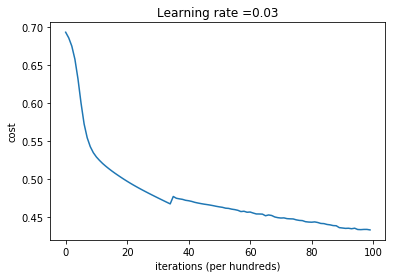

In [94]:
parameters = L_layer_model(X_trainset, y_trainset, layers_dims, learning_rate = 0.03,num_iterations = 10000, print_cost = True)

In [95]:
pred_train = predict(X_trainset, y_trainset, parameters)
pred_test = predict(X_testset, y_testset, parameters)

Accuracy: 0.7899375000000003
AUC: 0.8886644054608004
Accuracy: 0.7420000000000002
AUC: 0.826805257795751


In [96]:
# Using significant features
independent_all_dummy_2 = independent_all_dummy.loc[:,sig_fea]
X_trainset, X_testset, y_trainset, y_testset = train_test_split(independent_all_dummy_2, dependent, test_size=0.2, random_state=123)

In [97]:
# Explore dataset 
m_train = X_trainset.shape[0]
m_test = X_testset.shape[0]
X_trainset = X_trainset.T
y_trainset = y_trainset.reshape((1, y_trainset.shape[0]))
X_testset = X_testset.T
y_testset = y_testset.reshape((1, y_testset.shape[0]))

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("X_trainset shape: " + str(X_trainset.shape))
print ("y_trainset shape: " + str(y_trainset.shape))
print ("X_testset shape: " + str(X_testset.shape))
print ("y_testset shape: " + str(y_testset.shape))

Number of training examples: 16000
Number of testing examples: 4000
X_trainset shape: (320, 16000)
y_trainset shape: (1, 16000)
X_testset shape: (320, 4000)
y_testset shape: (1, 4000)


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


In [98]:
### CONSTANTS ###
layers_dims = [X_trainset.shape[0], 100, 50, 10, 1] #  4-layer model
layers_dims

[320, 100, 50, 10, 1]

Cost after iteration 0: 0.693187
Cost after iteration 100: 0.687328
Cost after iteration 200: 0.680348
Cost after iteration 300: 0.669774
Cost after iteration 400: 0.652571
Cost after iteration 500: 0.627115
Cost after iteration 600: 0.600199
Cost after iteration 700: 0.582151
Cost after iteration 800: 0.571554
Cost after iteration 900: 0.564140
Cost after iteration 1000: 0.558387
Cost after iteration 1100: 0.553625
Cost after iteration 1200: 0.549551
Cost after iteration 1300: 0.545932
Cost after iteration 1400: 0.542693
Cost after iteration 1500: 0.539681
Cost after iteration 1600: 0.536725
Cost after iteration 1700: 0.533833
Cost after iteration 1800: 0.530997
Cost after iteration 1900: 0.528186
Cost after iteration 2000: 0.525283
Cost after iteration 2100: 0.522387
Cost after iteration 2200: 0.519578
Cost after iteration 2300: 0.516781
Cost after iteration 2400: 0.514022
Cost after iteration 2500: 0.511349
Cost after iteration 2600: 0.508709
Cost after iteration 2700: 0.506227
Cost

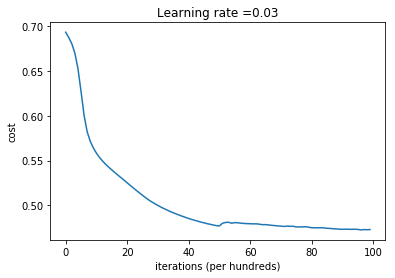

In [99]:
parameters = L_layer_model(X_trainset, y_trainset, layers_dims, learning_rate = 0.03,num_iterations = 10000, print_cost = True)

In [100]:
pred_train = predict(X_trainset, y_trainset, parameters)

Accuracy: 0.7435000000000003
AUC: 0.8471102124968408


In [101]:
pred_test = predict(X_testset, y_testset, parameters)

Accuracy: 0.7137500000000001
AUC: 0.8157973886031089
